This is the Notebook for the Araya coding work. All steps should be annotated for easy following. Any questions please contact Author.
I first carry out all imports. 
I get the Motor Imagery Dataset (BCI Competition IV Dataset 2a). I pre-process it as I see fit
 
I test a few decoding possibilities to pick which I will use for the online decoding. 
 - simple logistic regretion 
 - DL
 
I create server that streams the EEG dataset using LSL 
i get the client side that does online decoding with my model of choice 

In [50]:
import time

from pylsl import StreamInfo, StreamOutlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from mne.decoding import CSP


import mne
from mne.datasets import eegbci #dataset of choice for challenge 
from mne.io import concatenate_raws, read_raw_edf
from mne.decoding import Vectorizer, FilterEstimator

from mne_realtime import StimServer
from mne_realtime import MockRtClient

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim


In [10]:
#get mne dataset (raw)
# Download the dataset if not already downloaded
eegbci.load_data(1, [4, 8, 12,6,10,14], path='./datasets')# all moteor imagery runs 


Download complete in 34s (7.4 MB)


[WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf'),
 WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf'),
 WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf'),
 WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf'),
 WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf'),
 WindowsPath('datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf')]

In [16]:
# Define the channels and event id for motor imagery
channels = ['C3', 'Cz', 'C4']  # Channels of interest
event_id = dict(left_hand=2, right_hand=3, foot=4, tongue=5)


# Load the data for a specific subject
subject = 1
runs = [4, 8, 12,6,10,14]  # Motor imagery runs for subject 1
raw_files = [read_raw_edf(f'datasets/S00{subject}R{run}.edf', preload=True, stim_channel='auto') for run in runs]
raw = concatenate_raws(raw_files)

Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\S001R4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\S001R8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\Documents\bmi_comp\datasets\S001R6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from c:\Users\isabe\OneDrive\

In [32]:
#pre-processing
#filter raw data (8Hz,30Hz)
filtered_raw_data = raw.copy().filter(l_freq=7, h_freq=35, fir_design='firwin')
# raw_data.plot(title='no filter raw data')
# filtered_raw_data.plot(title='filtered data')
raw_data = filtered_raw_data
del filtered_raw_data

# resample the data to 100Hz
raw_data.resample(sfreq=100)
print(raw_data.info)##

raw_data.rename_channels(lambda x: x.strip('.'))


Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 100.0 Hz
 subject_info: 3 items (dict)
>


Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,7.00 Hz
Lowpass,30.00 Hz


In [31]:
from mne.channels import make_standard_montage

# Set channel names
eegbci.standardize(raw_data)
montage = make_standard_montage('standard_1005')
raw_data.set_montage(montage)
print(raw_data.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>


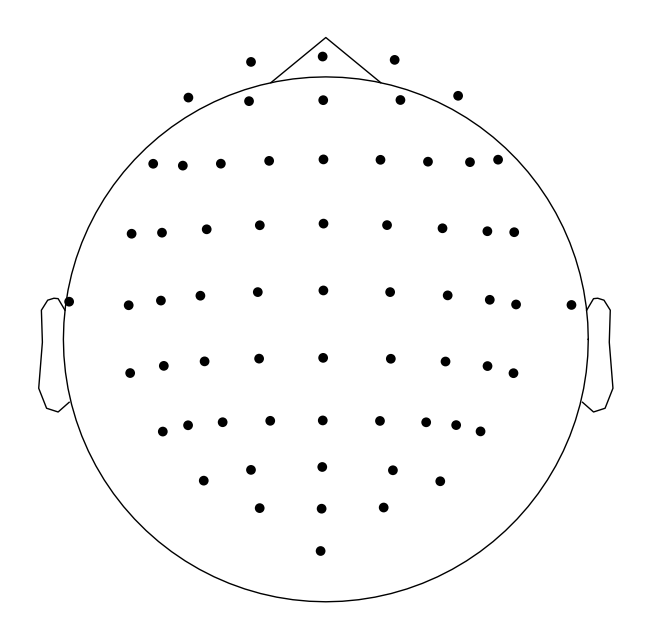

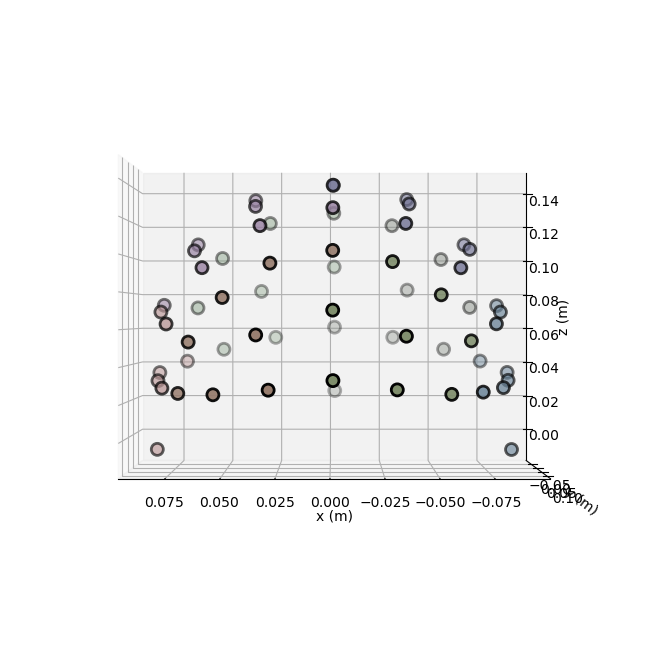

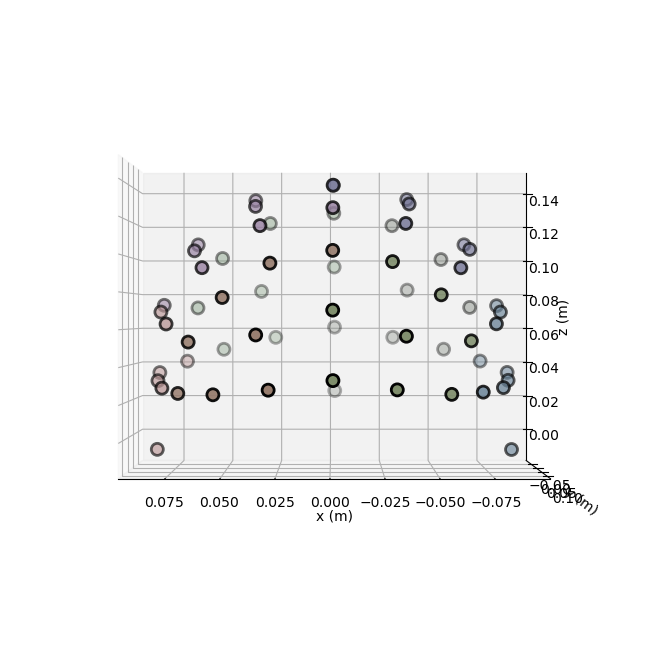

In [33]:
# Some visualisation 
raw.plot_sensors(ch_type='eeg')
raw.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


c:\Users\isabe\anaconda3\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


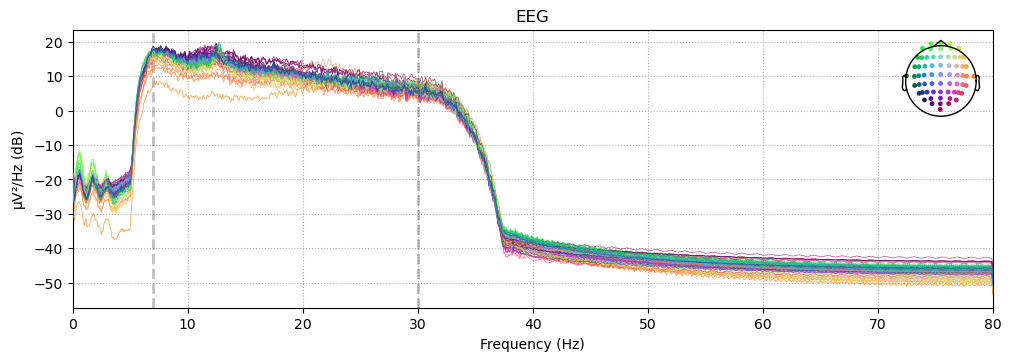

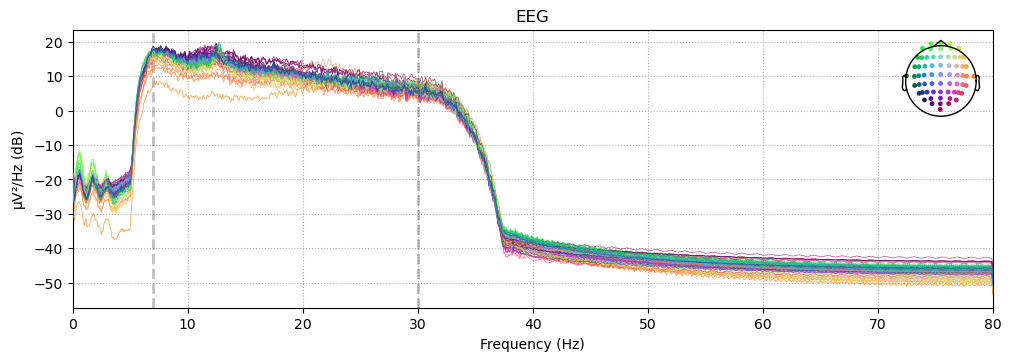

In [34]:
# plotting power specrum 
raw.plot_psd()

In [35]:
from mne import pick_types

# Select EEG channels
picks = pick_types(raw.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   exclude='bads')

In [36]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = 1., 2.
event_id=dict(hands=2, feet=3)

# Get events from an Annotations object.
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))

# Read epochs
epochs = Epochs(raw,
                events,
                event_id,
                tmin,
                tmax,
                proj=True,
                picks=picks,
                baseline=None,
                preload=True)

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: ['T1', 'T2']
Found 90 events
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 161 original time points ...
0 bad epochs dropped
<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>
events x channels x samples: (90, 64, 161)


In [37]:

# Prepare features and labels
X = epochs.get_data()  # EEG data
y = epochs.events[:, -1]  # Event labels (0: left hand, 1: right hand)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\isabe\AppData\Local\Temp\ipykernel_4044\3934351357.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # EEG data


Now We have the data set up, I will carry out different classifications to then pick the prefered popeline

In [40]:
# start simple with a K-fold cross validation 
cv = KFold(n_splits=10, shuffle=True, random_state=42)
epochs_data = 1e6 * epochs.get_data()



# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" 
                                  % (np.mean(scores), class_balance))

Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 64 dim * 1.2e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors


C:\Users\isabe\AppData\Local\Temp\ipykernel_4044\1781347366.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = 1e6 * epochs.get_data()


Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1.1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e+02 (2.2e-16 eps * 64 dim * 1e+16  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Us

In [41]:
%%capture
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)


In [55]:
# here i use a deep learning model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(64, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(2, 32), stride=(1, 1), padding=(0, 16))
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 2 * 15, 3)  # 4 output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=(1, 4), stride=(1, 4))
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=(1, 4), stride=(1, 4))
        x = x.view(-1, 32 * 2 * 15)
        x = self.fc1(x)
        return x

In [69]:
class EEGNetReproduce(nn.Module):
    def __init__(self, n_channels, n_classes, input_window_size,
                 F1=8, D=2, F2=16, kernel_length=64, drop_p=0.25):
        super(EEGNetReproduce, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.kernel_length = kernel_length
        self.drop_p = drop_p
        self.input_windows_size = input_window_size
        self.block_temporal_conv = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_length),
                      stride=1, bias=False, padding='same'),
            nn.BatchNorm2d(self.F1)
        )
        self.block_spacial_conv = nn.Sequential(
            Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.n_channels, 1),
                                 max_norm=1, stride=1, bias=False, groups=self.F1, padding=(0, 0)),
            nn.BatchNorm2d(self.F1 * self.D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4)),
            nn.Dropout(p=self.drop_p)
        )
        self.block_separable_conv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, 16),
                      stride=1, bias=False, groups=self.F1 * self.D, padding='same'),
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 1),
                      stride=1, bias=False, padding=(0, 0)),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=self.drop_p),
            nn.Flatten()
        )
        block_conv = nn.Sequential(
            self.block_temporal_conv,
            self.block_spacial_conv,
            self.block_separable_conv
        )
        out = block_conv(torch.ones((1, 1, self.n_channels, self.input_windows_size), dtype=torch.float32))
        self.block_classifier = nn.Sequential(
            nn.Linear(out.cpu().data.numpy().shape[1], self.n_classes),
            # nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        while len(x.shape) < 4:
            x = x.unsqueeze(-1)
        x = x.permute(0, 3, 1, 2)
        x = self.block_temporal_conv(x)
        x = self.block_spacial_conv(x)
        x = self.block_separable_conv(x)
        x = self.block_classifier(x)
        return x


class BaseCNN(nn.Module):
    def __init__(self, n_channels, n_classes, input_window_size):
        super(BaseCNN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.input_window_size = input_window_size
        self.block_conv = nn.Sequential(
            nn.Conv2d(64, 16, (1, 8), stride=1, padding='same'),
            nn.BatchNorm2d(16, momentum=0.01, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8)),
            nn.Dropout(p=0.5)
        )
        self.block_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(self.input_window_size // 8 * self.n_channels * 16, 64),
            nn.Linear(64, self.n_classes),
            # nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = transpose_to_4d_input(x)
        x = self.block_conv(x)
        x = self.block_classifier(x)
        return x

def transpose_to_4d_input(x):
    # Reshape the input tensor to have dimensions (batch_size, channels, height, width)
    return x.unsqueeze(1)

In [62]:
n_channels = 64  # Example number of input channels
n_classes = 4  # Example number of output classes
input_window_size = 512  # Example size of the input window
modelCNN = BaseCNN(n_channels, n_classes, input_window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [61]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [79]:
class BaseCNN(nn.Module):
    def __init__(self, n_channels, n_classes, input_time_steps):
        super(BaseCNN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.input_time_steps = input_time_steps
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 8), stride=1, padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8))
        
        # Calculate the number of output features from convolutional layers
        conv_out_time_steps = (input_time_steps - 8 + 1) // 8
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(16 * n_channels * conv_out_time_steps, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Add a channel dimension to the input data
        x = x.unsqueeze(1)
        
        # Apply convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Reshape the output for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [80]:
n_channels = 64  # Number of input channels
n_classes = 4  # Number of output classes
input_time_steps = 161  # Number of time steps in input data

# Initialize the model
model = BaseCNN(n_channels=n_channels, n_classes=n_classes, input_time_steps=input_time_steps)

In [81]:
# Train [model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 1.3321
Epoch [2/10], Loss: 1.3302
Epoch [3/10], Loss: 1.3476
Epoch [4/10], Loss: 1.3468
Epoch [5/10], Loss: 1.3630
Epoch [6/10], Loss: 1.3939
Epoch [7/10], Loss: 1.3486
Epoch [8/10], Loss: 1.3156
Epoch [9/10], Loss: 1.3465
Epoch [10/10], Loss: 1.3478
Accuracy on test set: 44.44%


Now I have understood how the data behaves with my models, I will build the server and client stream:

In [84]:
# Server 
# Define constants
channels = 64  # Number of EEG channels
sampling_rate = 160  # Sampling rate in Hz
stream_name = 'MotorImageryStream'
stream_type = 'EEG'

# Create a stream info object
info = StreamInfo(stream_name, stream_type, channels, sampling_rate, 'float32', 'myuid12345')

# Create a stream outlet
outlet = StreamOutlet(info)

#lets do it!
print("Streaming EEG data...")
# streaming EEG data
while True:
    # get data
    eeg_data = X_test
    
    # Send the EEG data sample
    outlet.push_sample(eeg_data)
    
    # Sleep for a short duration to control the data stream rate
    time.sleep(1/sampling_rate)
print("Streaming finished.")


Streaming EEG data...


TypeError: only length-1 arrays can be converted to Python scalars

In [83]:
X_test.shape

(18, 64, 161)

In [ ]:
# client side
streams = resolve_stream('type', 'EEG')

# Create an inlet to receive the EEG stream
inlet = StreamInlet(streams[0])

# Receive and decode EEG data
print("Receiving EEG data...")
try:
    while True:
        # Receive a chunk of EEG data
        chunk, timestamps = inlet.pull_chunk(timeout=1.0)
        
        # Check if any data chunk was received
        if chunk:
            # Process and decode the received EEG data
            for sample in chunk:
                # Perform decoding or analysis on the EEG data
                # Example: Print the received EEG sample
                print("Received EEG sample:", sample)
except KeyboardInterrupt:
    print("Client stopped.")